In [7]:
#import packages
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import astropy.io.fits as fits
import glob
import os
import pyklip
import pyklip.klip as klip
from pyklip.fmlib.diskfm import DiskFM
import pyklip.fm as fm
import pyklip.parallelized as parallelized
from pyklip.kpp.utils.mathfunc import *
from pyklip.kpp.metrics.crossCorr import calculate_cc
from pyklip.instruments.Instrument import GenericData
import pyklip.instruments.NIRC2 as NIRC2
import astropy.units as u
from pyklip.kpp.stat.stat_utils import get_image_stat_map
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift
from photutils.centroids import centroid_2dg
import warnings
import pyklip.fm as fm
import pyklip.fmlib.fmpsf as fmpsf
import pyklip.fitpsf as fitpsf
import pyklip.fakes as fakes
from astropy.modeling import models, fitting
import math
import lmfit
%matplotlib inline

warnings.filterwarnings("ignore")
print("Imported packages.")

Imported packages.


In [9]:
#gaussian model generator for FM planet PSF
def makeGaussian(size, amplitude = 1, fwhm = 3, center=None):
    #from andrewgiessel on github

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return amplitude * np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

def fitPrimary(x0, y0, im, radius=10, xIndex=None, yIndex=None,
               weight=None, mask=None,
               returnModel=False):
    """
    fit a 2d gaussian to the region of interest and return the fitted x and y
    """
    if xIndex is None:
        xIndex = np.arange(im.shape[1]).astype(int)
    if yIndex is None:
        yIndex = np.arange(im.shape[0]).astype(int)

    subXIndex, = np.where(np.abs(xIndex - x0) < radius)
    subYIndex, = np.where(np.abs(yIndex - y0) < radius)

    yyIndex, xxIndex = np.meshgrid(subYIndex, subXIndex,
                                   indexing='ij')
    yy, xx = np.meshgrid(yIndex[subYIndex], xIndex[subXIndex],
                         indexing='ij')

    subim = im[yyIndex.astype(int), xxIndex.astype(int)]

    if weight is None:
        subweight = np.ones_like(subim)
    else:
        subweight = weight[subYIndex, subXIndex]

    if mask is None:
        mask = np.zeros_like(subim)
    else:
        # if there are masked pixel, set the corresponding pixels' weight to 0
        weight[np.where(mask) != 0] = 0
    p = Parameters()
    p.add('g_centerx', value=x0)
    p.add('g_centery', value=y0)
    p.add('g_amplitude', value=np.nanmax(subim))
    p.add('g_sigmax', value=1, min=0)
    p.add('g_sigmay', value=1, min=0)
    p.add('c_c', value = 0)
    pFit = gModel.fit(subim, params=p, x=xx, y=yy, weights=subweight,
                      verbose=True,
                      method='powell',
                      nan_policy='omit')
    modelImage = np.zeros_like(im) 
    modelImage[yyIndex.astype(int), xxIndex.astype(int)] = pFit.best_fit.reshape(yy.shape) 

    print(pFit.fit_report())
    return pFit, modelImage

#classical ADI
def cADI_NIRC2(flist):
    
    rawcube = np.zeros((len(flist),1024,1024))
    aligned_cube = np.zeros((len(flist),1024,1024))
    cccube = np.zeros((1024,1024))
    subcube = np.zeros((len(flist),1024,1024))
    derotcube = np.zeros((len(flist),1024,1024))
    SNR_map = np.zeros((1024,1024))     
    ctrs=[]
    ctrPoisson = []
    vertangs = []
    x_grid,y_grid= np.meshgrid(np.arange(-10,10),np.arange(-10,10))
    kernel_gauss = gauss2d(x_grid,y_grid, amplitude = 40.0, xo = 0, yo = 0, sigma_x = .5, sigma_y = .5)
    
    for i in np.arange(len(flist)):
        rawcube[i,:,:] = fits.getdata(flist[i])
        head = fits.getheader(flist[i],ext=0)
        
        if i == 0:
            #ctrs.append((609, 436) + centroid_2dg(rawcube[0,609:613,436:442],error=None,mask=None)) #for Feb_2023
            #ctrs.append((605,430) + centroid_2dg(rawcube[0,605:620,430:440],error=None,mask=None)) #for Dec_2023
            ctrPoisson.append((611.4,436.2))
            
            aligned_cube[0,:,:] = rawcube[0,:,:]
        else:              
            shifts, error, diffphase = phase_cross_correlation(rawcube[0,:,:], rawcube[i,:,:],upsample_factor=100,normalization=None)
            aligned_cube[i,:,:] = fourier_shift(rawcube[i,:,:],shifts)
            #ctrs.append((609, 436) + centroid_2dg(rawcube[i,609:613,436:442],error=None,mask=None)) #for Feb_2023
            ctrs.append((605,430) + centroid_2dg(aligned_cube[i,605:620,430:440],error=None,mask=None)) #for Dec_2023
            ctrPoisson.append(ctrPoisson[0]+shifts)
        va = head['ROTPOSN'] - head['INSTANGL'] + head['PARANG']
        vertangs.append(va)

    fits.writeto('tempstar.fits',aligned_cube[1,:,:],overwrite=True)
    medcube = np.nanmedian(aligned_cube,axis=0)
    
    for i in np.arange(len(flist)):
        subcube[i,:,:] = aligned_cube[i,:,:] - medcube
        derotcube[i,:,:] = klip.rotate(subcube[i,:,:], vertangs[i], ctrPoisson[i]) ##check tutorial
        
        
    med_derot = np.nanmedian(derotcube, axis=0)
    cccube[:,:] = calculate_cc(med_derot[:,:],kernel_gauss,spectrum=None,nans2zero=True)
    SNR_map[:,:] = get_image_stat_map(cccube,
                                               centroid = ctrPoisson[0],
                                               r_step=.5,
                                               Dr = .5,
                                               type = "SNR")
    
    plt.plot(ctrPoisson)
    plt.show()
    plt.plot(vertangs)
    plt.show()
    
    fits.writeto('med_derotcube.fits',med_derot,overwrite=True)
    fits.writeto('snr_cccube.fits',SNR_map,overwrite=True)
    
    return SNR_map, med_derot, ctrs[0]

In [10]:
#returns median of aligned images to use as PSF
def ADI_psfs(psflist): 
    rawpsfs = np.zeros((len(psflist), 1024, 1024))
    adjustedpsfs = np.zeros((len(psflist), 1024, 1024))
    alignedpsfs = np.zeros((len(psflist), 1024, 1024))
    #shiftentries = (701-60, 487-32)
    for i in range(len(psflist)):
        rawpsfs[i,0:120,0:64] = fits.getdata(psflist[i])
        adjustedpsfs[i, 701-60:701+60,487-32:487+32] = rawpsfs[i,0:120,0:64] // 3000 #normalize to background of zeroes, values used to be order of millions
        #adjustedpsfs[i,:,:] = fourier_shift(rawpsfs[i,:,:], shiftentries)
        if i != 0:
            shifts, error, diffphase = phase_cross_correlation(alignedpsfs[0,:,:], adjustedpsfs[i,:,:], upsample_factor=100)
            alignedpsfs[i,:,:] = fourier_shift(adjustedpsfs[i,:,:], shifts)
        else:
            alignedpsfs[0,:,:] = adjustedpsfs[0,:,:]
            
    medpsfs = np.nanmedian(alignedpsfs, axis=0)

    
    return np.array([medpsfs])

    



#returns fits-processed images, centers, and parallactic angles for every file in the list with given dimensions
def ADI_getImages(flist, xdim, ydim, print_header=False):
    rawcube = np.zeros((len(flist),xdim,ydim))
    ctrs= np.zeros((len(flist),2))
    parangs = np.zeros((len(flist)))
    
    boxrad = 5
    cx, cy = 599, 454
    b, t, l, r = cy - boxrad, cy + boxrad, cx - boxrad, cx + boxrad
    threshold = 5.5
    for i in np.arange(len(flist)):
        rawcube[i,:,:] = fits.getdata(flist[i])
        head = fits.getheader(flist[i],ext=0)

        if print_header and i==0:
            print(head)

        # if i == 0:
        #     print(head)
        # print(head['ITIME'])
        # print(head['COADDS'])
        #find centers
        
        ctrs[i] = (l, b) + centroid_2dg(rawcube[i,b:t,l:r])
        # fits.writeto(f'test/{i}.fits', rawcube[i,b:t,l:r], overwrite=True)
        
        if ctrs[i][0] > r or ctrs[i][0] < l or ctrs[i][1] > t or ctrs[i][1] < b:
            print(f'adjusting image {i} with phase_cross_correlation...')
            shift, error, diffphase = phase_cross_correlation(rawcube[0,:,:], rawcube[i,:,:], upsample_factor=100, normalization=None)
            ctrs[i] = ctrs[0] - shift

        # if i > 0:
        #     movement = abs(ctrs[i][1] - ctrs[i-1][1]) + abs(ctrs[i][0] - ctrs[i-1][0])
        #     if i != 10 and movement > threshold:
        #         print(i, movement)
        #         ctrs[i] = ctrs[i - 1]
        # if i == 0:
        #     print(b, t, l, r)
        #     ctrs[i] = (l, b) + centroid_2dg(rawcube[0,b:t,l:r])
            
                                                    #12_Kshort: (618, 431)
                                                    #02_H: (613, 433)
                                                    #12_CH4short: (599, 454)
                                                    #12_J: (611, 436)
            
        # else:
        #     shifts, error, diffphase, = phase_cross_correlation(rawcube[0,:,:],rawcube[i,:,:],
        #                                             upsample_factor=100,
        #                                             normalization=None)
        #     ctrs[i] = ctrs[0] - shifts
            
        parangs[i] = head['PARANG']

    ydat, xdat = np.indices(rawcube[0].shape)
    for i in range(len(flist)):
        rawTemp = np.copy(rawcube[i])
        cx, cy = ctrs[i]

        rawTemp[int(cy),int(cx)] = np.nan
        
        # rawTemp[b,l:r], rawTemp[t,l:r], rawTemp[b:t, l], rawTemp[b:t, r] = np.nan, np.nan, np.nan, np.nan
        # distance_from_center = np.sqrt((xdat - cx)**2 + (ydat-cy)**2)
        # rawTemp[np.where(distance_from_center <= 3)] = np.nan

        # plt.imshow(rawTemp[b-5:t+5,l-5:r+5], cmap='gray', origin='lower')
        # plt.plot(cx-(l-5), cy-(b-5), 'ro')
        # plt.show()
    
        # fits.writeto(f'../rawPlusCenters/2023_02_H/n{i}.fits', rawTemp, overwrite=True)

    
    
    # distance_from_center = np.sqrt((xdat - ctrs[0][0])**2 + (ydat-ctrs[0][1])**2)
    # medcube = np.nanmedian(rawcube, axis=0)
    # newMedCube = np.copy(medcube)
    # newMedCube[np.where(distance_from_center <= 3)] = np.nan
    # fits.writeto('medIMG.fits', newMedCube, overwrite=True)
    
    # tempCube = np.copy(rawcube[0,:,:])
    # tempCube[np.where(distance_from_center <= 3)] = np.nan
    # fits.writeto('rawIMG.fits', tempCube, overwrite=True)

    # cx, cy = int(ctrs[0][0]), int(ctrs[0][1])
    # b, t, l, r = cy - boxrad, cy + boxrad, cx - boxrad, cx + boxrad
    # print(cx, cy, b, t, l, r)
    # centroid = centroid_2dg(medcube[b:t, l:r])
    # print(centroid)
    # distance_from_center_2 = np.sqrt((xdat - l - centroid[0])**2 + (ydat - b - centroid[1])**2)
    # tempCube2 = np.copy(medcube)
    # tempCube2[np.where(distance_from_center_2 <= 3)] = np.nan
    # tempCube2[b,l:r], tempCube2[t,l:r], tempCube2[b:t, l], tempCube2[b:t, r] = np.nan, np.nan, np.nan, np.nan
    # fits.writeto('centroidIMG.fits', tempCube2, overwrite=True)
    
    plt.plot(ctrs)
    return rawcube, ctrs, parangs


#ADI
def ADI_NIRC2(flist, band):
    rawcube, ctrs, parangs = ADI_getImages(flist, 1024, 1024)
            
    dataset = GenericData(rawcube, ctrs, IWA=6, parangs=parangs)
    sub_imgs = parallelized.klip_dataset(dataset, outputdir=f'../klipdata/{subdir}',
                                        annuli=9,subsections=4,numbasis=[1,7,15,30],maxnumbasis=150,mode="ADI",
                                        movement=1)

    return sub_imgs, ctrs[0]


#fake planet injection for contrast calibration
def injectFakePlanets(flist, stellar_flux):
    datacube, ctrs, parangs = ADI_getImages(flist, 1024, 1024)
    dataset = GenericData(datacube, ctrs, IWA=6  , parangs=parangs)
    
    input_planet_fluxes = [1e-6, 2e-7, 4e-8, 8e-9]
    seps = [100, 200, 300, 400]
    fwhm = 2.5

    for input_planet_flux, sep in zip(input_planet_fluxes, seps):
        injected_flux = input_planet_flux * stellar_flux
        for pa in [0, 90, 180, 270]:
            fakes.inject_planet(dataset.input, dataset.centers, injected_flux, dataset.wcs, sep, pa, fwhm=fwhm)

    parallelized.klip_dataset(dataset, outputdir='../klipdata/2023_12_CH4short', fileprefix='fakes',
                              annuli=9, subsections=4, numbasis=[1,20,50,100], calibrate_flux=True,
                              mode='ADI')
    return input_planet_fluxes, seps, dataset.wcs

#Forward-Modeling
def forwardmodel(flist, psflist=None, gaussian=None, fwhm=3):
    datacube, ctrs, parangs = ADI_getImages(flist, 1024, 1024)
    dataset = GenericData(datacube, ctrs, IWA=6, parangs=parangs)
    
    numbasis = np.array([1, 20, 50, 100])
    guesssep = 191
    guesspa = 7.8
    # guesspa = 7.3        #for 2023_02_H
    guessflux = 1.0

    if len(gaussian) > 0:
        print('Gaussian')
        fm_psf_stamp = gaussian
        fits.writeto('gaussian_model.fits', fm_psf_stamp, overwrite=True)
    elif len(psflist) > 0:
        print('PSF')
        instrument_psfs = ADI_psfs(psflist)
        fm_psf_stamp = instrument_psfs[0, 691:711, 477:497]
        fits.writeto('psf_stamp.fits', fm_psf_stamp, overwrite=True)
    else:
        return

    # print(datacube.shape)
    # print(fm_psf_stamp.shape)
    fm_psf_stamp = fm_psf_stamp.reshape(1, fm_psf_stamp.shape[0], fm_psf_stamp.shape[1])

    fm_class = fmpsf.FMPlanetPSF(fm_psf_stamp.shape, numbasis, guesssep, guesspa, guessflux, fm_psf_stamp,
                             input_wvs = np.unique(dataset.wvs), flux_conversion = [1]*datacube.shape[0])

    outputdir = f"../fmdata/FM_2023_{band}/cleaned/"

    """   ___CHANGE THIS___   """
    
    prefix = f'fwhm={fwhm}'
    annulus_bounds = [[guesssep-15, guesssep+15]] 
    subsections = 1 
    padding = 0
    movement = 4

    fm.klip_dataset(dataset, fm_class, outputdir=outputdir, fileprefix=prefix, numbasis=numbasis,
                annuli=3, subsections=subsections, padding=padding, movement=movement)

def processFMObject(band, fwhm):
    #next step:
    #exposure time comparison, adjust psfs vs planet images because its measured in absolute counts
    # read in outputs
    output_prefix = f'../fmdata/FM_2023_{band}/science_dewarped_cleaned/fwhm={fwhm}'
    fm_hdu = fits.open(output_prefix + "-fmpsf-KLmodes-all.fits")
    data_hdu = fits.open(output_prefix + "-klipped-KLmodes-all.fits")
    
    # get FM frame
    fm_frame = fm_hdu[0].data[1]
    fm_centx = fm_hdu[0].header['PSFCENTX']
    fm_centy = fm_hdu[0].header['PSFCENTY']
    
    # get data_stamp frame
    data_frame = data_hdu[0].data[1]
    data_centx = data_hdu[0].header["PSFCENTX"]
    data_centy = data_hdu[0].header["PSFCENTY"]
    
    # get initial guesses
    guesssep = fm_hdu[0].header['FM_SEP']
    guesspa = fm_hdu[0].header['FM_PA']

    fit = fitpsf.FMAstrometry(guesssep, guesspa, 13, method="mcmc")
    fit.generate_fm_stamp(fm_frame, [fm_centx, fm_centy], padding=5)
    fit.generate_data_stamp(data_frame, [data_centx, data_centy], dr=4, exclusion_radius=10)
    corr_len_guess = 3.
    corr_len_label = r"$l$"
    fit.set_kernel("matern32", [corr_len_guess], [corr_len_label])
    # set bounds
    x_range = 1.5 # pixels
    y_range = 1.5 # pixels
    flux_range = 1. # flux can vary by an order of magnitude
    corr_len_range = 1. # between 0.3 and 30
    fit.set_bounds(x_range, y_range, flux_range, [corr_len_range])
    
    
    # run MCMC fit
    fit.fit_astrometry(nwalkers=100, nburn=200, nsteps=800, numthreads=1)
    fig = pylab.figure(figsize=(10,8))
    
    # # grab the chains from the sampler
    chain = fit.sampler.chain
    
    # plot RA offset
    ax1 = fig.add_subplot(411)
    ax1.plot(chain[:,:,0].T, '-', color='k', alpha=0.3)

    ax1.set_xlabel("Steps")
    ax1.set_ylabel(r"$\Delta$ RA")
    
    # plot Dec offset
    ax2 = fig.add_subplot(412)
    ax2.plot(chain[:,:,1].T, '-', color='k', alpha=0.3)
    ax2.set_xlabel("Steps")
    ax2.set_ylabel(r"$\Delta$ Dec")
    
    # plot flux scaling
    ax3 = fig.add_subplot(413)
    ax3.plot(chain[:,:,2].T, '-', color='k', alpha=0.3)
    ax3.set_xlabel("Steps")
    ax3.set_ylabel(r"$\alpha$")
    
    # plot hyperparameters.. we only have one for this example: the correlation length
    ax4 = fig.add_subplot(414)
    ax4.plot(chain[:,:,3].T, '-', color='k', alpha=0.3)
    ax4.set_xlabel("Steps")
    ax4.set_ylabel(r"$l$")
    fig.savefig(band + '_mcmc.pdf')
    plt.close(fig)

    fig = pylab.figure()
    fig = fit.make_corner_plot(fig=fig)
    fig.savefig(band + '_corner.pdf')
    plt.close(fig)

    fig = pylab.figure()
    fig = fit.best_fit_and_residuals(fig=fig)
    fig.savefig(f'cleaned/{band}_best_{fwhm}.pdf')
    plt.close(fig)

    # print(fig)

    # # get residuals
    # print(fit.fit_flux.bestfit)
    # print(fit.fit_x.bestfit, fit.fit_y.bestfit)
    # print(fit.data_stamp_x_center, fit.data_stamp_y_center)
    # print(fit.fm_stamp)

    # print(fit.fit_x.bestfit, fit.fit_y.bestfit)
    # print(dx, dy)
    # img = fit.data_stamp - fm_bestfit[5:-5, 5:-5]#float(fm_bestfit[5:-5, 5:-5])
    # stampcx, stampcy = fit.fit_x.bestfit - 5, fit.fit_y.bestfit - 5
    # central_residuals = np.matrix(img[2:-4, 2:-4]).astype(np.float32)
    # central_residuals = central_residuals ** 2

    # fits.writeto('bestfit.fits', np.matrix(fm_bestfit[5:-5, 5:-5]).astype(np.float32), overwrite=True)
    # fits.writeto('residual_test.fits', central_residuals, overwrite=True)
    # print(np.matrix.sum(np.matrix(img[]).astype(np.float32)))
    # fits.writeto('residual_test.fits', img, overwrite=True) 
    
    # fit.propogate_errs(star_center_err=0.05, platescale=.009971, platescale_err=0.000004, pa_offset=0.0, pa_uncertainty=0.13)

    # print("\nPlanet Raw RA offset is {0} +/- {1}, Raw Dec offset is {2} +/- {3}".format(fit.raw_RA_offset.bestfit, fit.raw_RA_offset.error,
    #                                                                                     fit.raw_Dec_offset.bestfit, fit.raw_Dec_offset.error))
    
    # # Full error budget included
    # print("Planet RA offset is at {0} with a 1-sigma uncertainity of {1}".format(fit.RA_offset.bestfit, fit.RA_offset.error))
    # print("Planet Dec offset is at {0} with a 1-sigma uncertainity of {1}".format(fit.Dec_offset.bestfit, fit.Dec_offset.error))
    
    # # Propogate errors into separation and PA space
    # print("Planet separation is at {0} with a 1-sigma uncertainity of {1}".format(fit.sep.bestfit, fit.sep.error))
    # print("Planet PA at {0} with a 1-sigma uncertainity of {1}".format(fit.PA.bestfit, fit.PA.error))

    # # Propagate errors into flux/alpha
    print("Planet flux scaler value (alpha) is at {0} with a 1-sigma uncertainty of {1}".format(fit.fit_flux.bestfit, fit.fit_flux.error))

    # # return different things
    return fit
    # return fit.fit_flux.bestfit, fit # np.matrix.sum(np.matrix(residual_img.astype(np.float32)))

import scipy.ndimage as ndi

def extract_residuals(fit):
    dx, dy = fit.fit_x.bestfit - fit.data_stamp_x_center, fit.fit_y.bestfit - fit.data_stamp_y_center
    fm_bestfit = fit.fit_flux.bestfit * ndi.shift(fit.fm_stamp, [dy, dx])
    residual_img = fit.data_stamp - fm_bestfit[5:-5, 5:-5]
    
    plt.imshow(residual_img, cmap='viridis', origin='lower')
    plt.show()

    return residual_img, np.matrix.sum(np.matrix(residual_img))

def test_fwhm_plot_residuals(subdir, lo, hi, inc):
    datadir = f'../rawdata/{subdir}/'
    flist = sorted(glob.glob(datadir + '*.fits'), reverse=True)
    ADI_getImages(flist, 1024, 1024, print_header=True)

    fwhms = []
    residuals = []
    
    for fwhm in np.arange(lo, hi, inc):
        fwhms.append(fwhm)

        # uncomment if images aren't already generated
        gaussian = makeGaussian(size=15, amplitude=30, fwhm=fwhm)
        gaussian_base_signal = np.matrix.sum(np.matrix(gaussian))
        forwardmodel(flist[2:], gaussian=gaussian, fwhm=fwhm)

        fit = processFMObject(band, fwhm)
        residual_img, residual_sum = extract_residuals(fit)
        residuals.append(residual_sum)

    plt.plot(fwhms, residuals)

# KLIP reduced images: eliminate some of the outlier pixels (interpolate -- take avg of pixels around unusually bright ones, do this for input image)
#     !! keep this aside, await yifan bc he might have an example for you
# FM images: use Powerpoint and 
#    a) eliminate X, Y, number labels
#    b) bring all pictures closer together in tight 3x4 grid
#    c) eliminate all but the top DATA | BEST | RESIDUAL labels
#    d) put label in corner of residuals plot (wherever is easiest to read)
# (1) J Best fit: a bit wide, run that again and check that its really the best
# CMD: determine and add uncertainty
#    a) anticipate we might need to workshop the plotting style, font size of labels
# Phot: double check that model can display CH4 short -- is the square the CH4 short point? how to plot CH4 short on the graph?
#    a) blue dot --> different, more readable color
#    b) fill circle for data, hollow circle for average/model expected value
#    c) (2) for corner plot, adjust range of temperature so that it's in the middle of its panel (bottom left, might have to run fit again)
#    d) provide 1-2 more models/plots in the appendix (maybe sonora?)
# Tables
#    a) use deluxe table environment
#    b) seq = star, companion, star --> first frame of stellar images is UT start, last is UT end, keep exposure times (companion & star) though
#    c) also add num_stellar_frames, num_companion_frames, UT start + UT end after comp/star time
#    d) at most 1, maybe 2 significant digits
# Contrast
#    a) (1) double check uncertainty values --> just re-run the FM for everything
    

In [ ]:
#   ___CHANGE THIS___   """

# band='12_H'
# datadir=f'../rawdata/2023_{band}/'
# flist = sorted(glob.glob(datadir + '*.fits'), reverse=True)
# print(band)
# print(fits.getheader(flist[0])['TRUITIME'])

conv = 2*math.sqrt(2*math.log(2))
# print(math.log(2))

# fwhms = {
#     '02_H': 2.03060614 * conv,
#     '12_Kshort': 1.990643135 * conv,
#     '12_CH4short': 1.557713995 * conv,
#     # '12_J': 2.06846173 * conv
#     '12_J': 1.5 * conv
# }
    
band = '12_CH4short'
fwhm = 1.557713995 * conv
subdir = f'2023_{band}/science_dewarped_cleaned'

datadir=f'../rawdata/{subdir}/'
flist = sorted(glob.glob(datadir + '*.fits'), reverse=True)

gaussian = makeGaussian(size=15, amplitude=30, fwhm=fwhm)
gaussian_base_signal = np.matrix.sum(np.matrix(gaussian))
forwardmodel(flist, gaussian=gaussian, fwhm=fwhm)

# ADI_NIRC2(flist, subdir)

    
# test_fwhm_plot_residuals(band, 3.0, 6.5, 0.5)


# datadir = f'../rawdata/2023_{band}/'
# flist = sorted(glob.glob(datadir + '*.fits'), reverse=True)
# ADI_getImages(flist, 1024, 1024, print_header=True)
# # ADI_getImages(flist, 1024, 1024)
# #psflist = sorted(glob.glob(psfdir + '*.fits'))

# gaussian = makeGaussian(size=15, amplitude=30, fwhm=fwhms[band])
# gaussian_base_signal = np.matrix.sum(np.matrix(gaussian))
# # print(gaussian_base_signal)
# forwardmodel(flist[2:], gaussian=gaussian, fwhm=fwhms[band])


# for val in fwhm:
#     gaussian = makeGaussian(size=120, amplitude=30, fwhm=val)
#     #fits.writeto('gaussian_psf.fits', gaussian, overwrite=True)
#     gaussian_base_signal = np.matrix.sum(np.matrix(gaussian))
#     forwardmodel(flist, gaussian=gaussian, fwhm=val)


#ADI_getImages(flist, 1024, 1024)
    #2023_12_H a=30 fwhm=5
    #2023_12_J a=60 fwhm=4
    #2023_12_CH4short a=60 fwhm=4
    #2023_12_Kshort a=25 fwhm=5
    #2023_02_H a=125 fwhm=4

#flist_adi, cen = ADI_NIRC2(flist)
#diskForwardmodel(flist, psflist)
#forwardmodel(flist, psflist)
#ADI_getImages(flist, 1024, 1024)
#ADI_NIRC2(flist)
#cADI_NIRC2(flist)
# forwardmodel(flist, gaussian=gaussian)
#flist_adi, cen = ADI_NIRC2(flist)
#input_planet_fluxes, seps, wcs = injectFakePlanets(flist, 179300000)

#2d plot centers

In [12]:
def makeGaussian(size, amplitude = 1, fwhm = 3, center=None):
    #from andrewgiessel on github

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return amplitude * np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)
    
"""   ___CHANGE THIS___   """

alpha_flux = processFMObject(band, f'../fmdata/FM_2023_{band}/fwhm=3.532')

# for band in ['12_Kshort', '12_CH4short']:
#     alpha_flux = processFMObject(band, f'../fmdata/FM_2023_{band}/fwhm=f')
# print(alpha_flux * gaussian_base_signal)

# x = [4, 5, 5.5, 6, 7]
# residual_fluxes = []
# fluxes = []
# alphas = []
# for band in ['12_H', '12_J', '02_H']:
#     for i in x:
#         print('fwhm =', i)
#         psf_flux = np.matrix.sum(np.matrix(makeGaussian(size=120, amplitude=30, fwhm=i)))
#         alpha_flux, total_flux, residuals = processFMObject(output_prefix + f'{band}/fwhm={i}')
#         residual_fluxes.append(residuals)
#         fluxes.append(total_flux)
#         alpha = alpha_flux * psf_flux
#         alphas.append(alpha_flux)
#         print(total_flux, alpha_flux * psf_flux)   # (!) which of these values is right? does it make a difference?

Running burn in
Burn in finished. Now sampling posterior
MCMC sampler has finished
Raw X/Y Centroid = (26.446881139488028, 189.7683562750804) with statistical error of [-0.09034121  0.08935257] pix in X and [-0.0714683   0.07194893] pix in Y
Raw Sep/PA Centroid = (191.60254609186566, 7.9340989551320895) with statistical error of [ 0.07351383 -0.07300236] pix in Sep and [ 0.02648341 -0.02678628] pix in PA
Adding in star center uncertainity
Converting pixels to milliarcseconds
Adding in plate scale error
Adding in a PA/North angle offset
Adding in PA uncertainity
Sep = 191.60254609186566 +/- 0.08869480996510969 ([0.08890603 0.08848359]) pix, PA = 7.9340989551320895 +/- 0.13354022195484416 ([0.13351002 0.13357043]) degrees
Sep = 1.9104689870819926 +/- 0.001170259498740079 ([0.00117185 0.00116867]) mas, PA = 7.9340989551320895 +/- 0.13354022195484416 ([0.13351002 0.13357043]) degrees
RA offset = 26.44688113948811 +/- 0.4426780574083967 ([0.44277839 0.44257773]) pix
Dec offset = 189.7683562

In [11]:
#calculate contrast

from scipy.ndimage import shift

star_itime = {
    '02_H': 0.014,
    '12_Kshort': 0.01,
    '12_CH4short': 0.01,
    '12_J': 0.01
}

#take in star data
def starData(band):
    
    star_path = f'../stardata/2023_{band}/*.fits'
    flist = sorted(glob.glob(star_path))
    
    # 20x20 slice containing brightest features of the star
    # aligned via centroid_2dg and shifting, then taking the sum of the median
    n = len(flist)
    rawcube = np.zeros((n, 15, 15))
    alignedcube = np.zeros((n, 13, 13))
    ctrs = []

    print(f'\n{band}')
    # print(fits.getheader(flist[0]))
    
    for i in range(n):
        # print(fits.getheader(flist[i])['ITIME'], fits.getheader(flist[i])['COADDS'])
        rawcube[i,:,:] = fits.getdata(flist[i])[50:65,25:40]
        if band == '12_H':
            rawcube[i,:,:] = fits.getdata(flist[i])[55:70,22:37]
        if band == '02_H':
            rawcube[i,:,:] = fits.getdata(flist[i])[122:137, 88:103]
        if band == '12_Kshort':
            if i >= 20:
                rawcube[i,:,:] = fits.getdata(flist[i])[39:54,22:37]
            else:
                rawcube[i,:,:] = fits.getdata(flist[i])[51:66,27:42]
        if band == '12_CH4short':
            if i >= 10:
                rawcube[i,:,:] = fits.getdata(flist[i])[54:69,22:37]
            else:
                rawcube[i,:,:] = fits.getdata(flist[i])[59:74,10:25]

        # ctrs.append((5, 5) + centroid_2dg(rawcube[i,5:10,5:10]))
        new_center = list(np.unravel_index(np.argmax(rawcube[i], axis=None), (15, 15)))
        ctrs.append(new_center)
        
        alignedcube[i,:,:] = shift(rawcube[i,:,:],shift=[7 - ctrs[i][0], 7 - ctrs[i][1]],mode='grid-constant')[1:-1,1:-1]
    
    peaks = [np.matrix.sum(np.matrix(alignedcube[i,:,:]))/(100*star_itime[band]) for i in range(len(alignedcube))]
    stddev = np.std(peaks)
    
    medcube = np.nanmedian(alignedcube, axis=0)

    
    print(band, np.matrix.sum(np.matrix(medcube))/(100*star_itime[band]), stddev)

    # check and save centers
    ydat, xdat = np.indices(rawcube[0].shape)
    for i in range(n):
        rawTemp = np.copy(alignedcube[i])
        
        
        cx, cy = ctrs[i]
        rawTemp[6,6] = 0
        
        # distance_from_center = np.sqrt((xdat - cx)**2 + (ydat-cy)**2)
        # rawTemp[np.where(distance_from_center <= 2)] = np.nan
        fits.writeto(f'../alignment/2023_{band}/n{i}.fits', rawTemp, overwrite=True)
        
    # print(medcube[0][0])
    # print(medcube.shape)
    # print(max(medcube))
    fits.writeto(f'medstar-{band}.fits', medcube, overwrite=True)
    # lmFitGaussian(medcube)
    return np.sum(medcube), medcube


def contrast(band):

    # band: [flux scaler, flux scaler error]
    alphas = {
        '12_H': [2.141395, 0.0725038],
        '12_J': [1.7848227590712247, 0.11250679521043616],
        '12_Kshort': [1.1388725743948742, 0.07582706324581101],
        '02_H': [17.100481864852497, 0.5593673842804723],
        '12_CH4short': [2.5082175841170398, 0.0884498430763454]
    }

    # band : truitime * num_coadds
    time = {
        '12_H': 7.9965 * 4,
        '12_J': 9.99671 * 3,
        '12_Kshort': 9.99671 * 3,
        '02_H': 10 * 3,
        '12_CH4short': 10 * 3
    }

    # star and planet fluxes in counts
    _, star_img = starData(band)
    pFit, best_im = fitPrimary(6, 6, star_img, radius=7, returnModel=True)
    star_counts = np.sum(best_im)
    planet_counts = alphas[band][0] * gaussian_base_signal

    # convert to fluxes by dividing by sampling rate
    planet_flux = planet_counts / time[band]
    # star_flux = star_counts / (100 * 0.0100113)
    star_flux = star_counts / (100 * star_itime[band])

    print('\nPre Conversion:')
    print(star_counts, planet_counts)

    print('\nPost Conversion:')
    print(star_flux, planet_flux)
    
    contrast = planet_flux / star_flux
    contrast_mag = math.log(contrast, 10) * -2.51

    print('\nContrast error:')
    print(math.log((alphas[band][0] + alphas[band][1]) / alphas[band][0]))

    return contrast, contrast_mag




import numpy as np
from lmfit import Model, Parameters
from lmfit.models import Gaussian2dModel, ConstantModel
from astropy.io import fits


gModel = Gaussian2dModel(prefix='g_') + ConstantModel(prefix='c_')


#map bands to apparent magnitude of HD47127
appmag = {
    '12_H': 5.277,
    '12_J': 5.561,
    '12_Kshort': 5.174,
    '02_H': 5.277,
    '12_CH4short': 5.383
}

distance = 26.6

conv = 2*math.sqrt(2*math.log(2))
print(math.log(2))

# fwhms = {
#     '02_H': 2.03060614 * conv,
#     '12_Kshort': 1.990643135 * conv,
#     '12_CH4short': 1.557713995 * conv,
#     # '12_J': 2.06846173 * conv
#     '12_J': 1.5 * conv
# }

for band in fwhms:

    gaussian = makeGaussian(size=15, amplitude=30, fwhm=fwhms[band])
    gaussian_base_signal = np.matrix.sum(np.matrix(gaussian))
    contrast_ratio, contrast_mag = contrast(band)
    
    apparent_magnitude = contrast_mag + appmag[band]
    absolute_magnitude = apparent_magnitude - 5 * math.log(distance, 10) + 5
    print(f'\nContrast magnitude, absolute magnitude for {band}')
    print(contrast_mag, absolute_magnitude)

# fitPrimary(7, 7, starData(band)[1], radius=8, returnModel=True)




#4 coadds for H coronagraph data
#9.99671 for J/Ks/CH4s, 7.9965 for H, should be less for CH4l
#true integration time of 0.0100113 sec and 100 coadds is standard across all non-coronagraphic images
##species fit -> Teff, Lbol
##template from astrophysical journal -> write stuff
##med combined star center -- 2x4 plot

#02_H klip reduction + alignment check
#orbit fit overleaf

#center first get images plotted with overlayed center coord

0.6931471805599453

02_H
02_H 91669145.58035715 10760613.069869723
[[Model]]
    (Model(gaussian2d, prefix='g_') + Model(constant, prefix='c_'))
[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 321
    # data points      = 169
    # variables        = 6
    chi-square         = 2.5083e+12
    reduced chi-square = 1.5389e+10
    Akaike info crit   = 3970.10558
    Bayesian info crit = 3988.88498
    R-squared          = 0.95607625
[[Variables]]
    g_centerx:    5.87638772 +/- 0.03650908 (0.62%) (init = 6)
    g_centery:    6.06592424 +/- 0.04471124 (0.74%) (init = 6)
    g_amplitude:  63313699.9 +/- 1296.47710 (0.00%) (init = 2945536)
    g_sigmax:     1.82896823 +/- 0.03224304 (1.76%) (init = 1)
    g_sigmay:     2.23224405 +/- 0.03991784 (1.79%) (init = 1)
    c_c:          386133.489 +/- 1296.48087 (0.34%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(g_amplitude, c_c)     = +0.5000
    C(g_sigmax, g_sigmay)   = -0.3426
    C(g_ce

In [53]:
def compareImgs(img1_prefix, img2_prefix):
    img1 = fits.open(img1_prefix + '-KLmodes-all.fits')[0].data[3]
    img2 = fits.open(img2_prefix + '-KLmodes-all.fits')[0].data[3]

    combinedTemp = img1 + img2
    fits.writeto('overlay_H_J.fits', combinedTemp, overwrite=True)

img1_prefix, img2_prefix = '../klipdata/2023_12_H/', '../klipdata/2023_12_J/'
compareImgs(img1_prefix, img2_prefix)

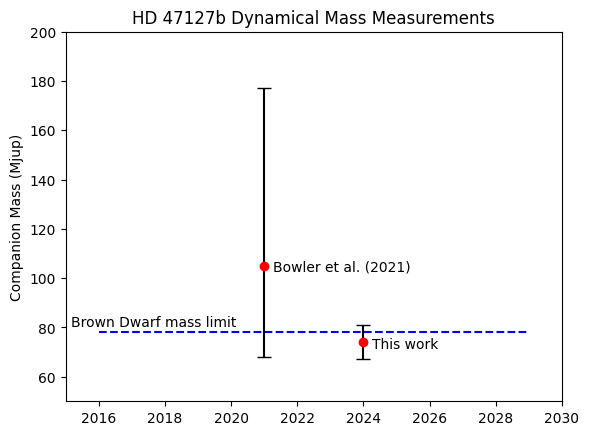

In [24]:
x = [2021, 2024]
y = [105.0, 73.5]
thresh = [78.0, 78.0]

y_min = [37, 6.9]
y_max = [72, 6.9]

plt.errorbar(x, y, yerr = [y_min, y_max], ls=' ', marker='o', color='red', capsize=5, capthick=1, ecolor='black')
plt.plot(list(np.arange(2016, 2030)), [78] * 14, color='blue', ls='--')
plt.ylabel('Companion Mass (Mjup)')
plt.title('HD 47127b Dynamical Mass Measurements')
plt.ylim(50, 200)
plt.xlim(2015, 2030)
plt.annotate('Bowler et al. (2021)', (2021, 105.0), textcoords='offset points', xytext=(6,-4)) 
plt.annotate('This work', (2024, 73.9), textcoords='offset points', xytext=(6,-4))
plt.annotate('Brown Dwarf mass limit', (2016, 80), textcoords='offset points', xytext=(-20, 1))
plt.savefig('HD47127b_mass.pdf')

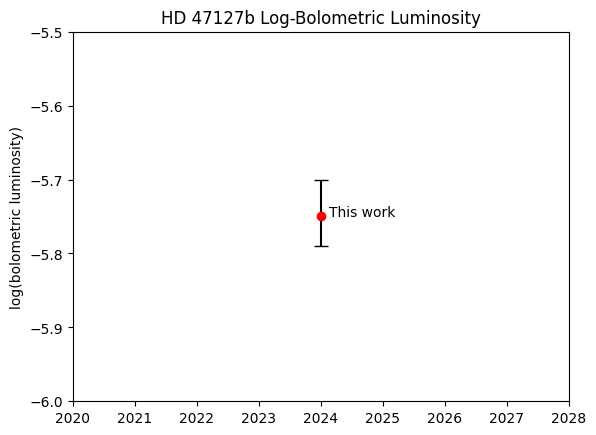

In [28]:
x = [2024]
y = [-5.75]
ymin, ymax = .04, .05

plt.errorbar(x, y, yerr=[[ymin], [ymax]], ls=' ', marker='o', color='red', capsize=5, capthick=1, ecolor='black')
plt.ylabel('log(bolometric luminosity)')
plt.title('HD 47127b Log-Bolometric Luminosity')
plt.ylim(-6, -5.5)
plt.xlim(2020, 2028)
plt.annotate('This work', (2024, -5.75), textcoords='offset points', xytext=(6,0))
plt.savefig('HD47127b_logluminosity.pdf')

In [5]:
def backgroundNoise(band):
    #next step:
    #exposure time comparison, adjust psfs vs planet images because its measured in absolute counts
    # read in outputs

    output_prefix = f"../fmdata/FM_2023_{band}/fwhm=f"
    fm_hdu = fits.open(output_prefix + "-fmpsf-KLmodes-all.fits")
    data_hdu = fits.open(output_prefix + "-klipped-KLmodes-all.fits")

    img = data_hdu[0].data[0]

    ydat, xdat = np.indices(img.shape)
    distance_from_center = np.sqrt((ydat - int(ctrs[band][1]))**2 + (xdat - int(ctrs[band][0]))**2)

    radial_pixels = np.where(abs(distance_from_center - int(pixel_sep[band])) < 2)
    zipRP = list(zip(radial_pixels[0], radial_pixels[1]))

    bgNoise = []
    
    for i in range(0, len(zipRP), 115):
        if abs(zipRP[i][0] - planet_placement[band][0]) < 10 and abs(zipRP[i][1] - planet_placement[band][1]) < 10:
            continue

        miny, maxy, minx, maxx = zipRP[i][1] - 7, zipRP[i][1] + 8, zipRP[i][0] - 7, zipRP[i][0] + 8
        img_sq = img[miny:maxy, minx:maxx]

        # print(zipRP[i], img[zipRP[i][1], zipRP[i][0]])

        bgNoise.append(np.matrix.sum(np.matrix(makeGaussian(size=15, amplitude=abs(img[zipRP[i][1], zipRP[i][0]])/alphas[band][0], fwhm=fwhms[band]))))

    avgBgNoise = sum(bgNoise) / len(bgNoise)

    signalModel = makeGaussian(size=15, amplitude=30, fwhm=fwhms[band])
    signal = np.matrix.sum(np.matrix(signalModel))
    
    return signal / time[band], avgBgNoise/time[band]
    

alphas = {
    '12_H': [2.141395, 0.0725038],
    '12_J': [1.7848227590712247, 0.11250679521043616],
    '12_Kshort': [1.1388725743948742, 0.07582706324581101],
    '02_H': [17.100481864852497, 0.5593673842804723],
    '12_CH4short': [2.5082175841170398, 0.0884498430763454]
}
    
fwhms = {
    '02_H': 2.00 * 2.355,
    '12_Kshort': 1.99 * 2.355,
    '12_CH4short': 1.55 * 2.355,
    '12_J': 2.05 * 2.355
}

ctrs = {
    '02_H': (433.833 - 1, 613.833 - 1),
    '12_Kshort': (431 - 1, 618 - 1),
    '12_CH4short': (453 - 1, 599.4 - 1),
    '12_J': (436 - 1, 611.5 - 1)
}

pixel_sep = {
    '02_H': 191.838,
    '12_Kshort': 191.623,
    '12_CH4short': 190.659,
    '12_J': 191.578
}

planet_placement = {
    '02_H': (624 - 1, 589 - 1), 
    '12_Kshort': (621 - 1, 590 - 1),
    '12_CH4short': (573 - 1, 642 - 1),
    '12_J': (625.3 - 1, 585.6 - 1)
}

time = {
    '12_H': 7.9965 * 4,
    '12_J': 9.99671 * 3,
    '12_Kshort': 9.99671 * 3,
    '02_H': 10 * 3,
    '12_CH4short': 10 * 3
}

print('(alpha, alphaError)')
for band in fwhms:
    print(band, alphas[band])

print('\n(planetCounts, planetError)')
for band in fwhms:
    print(band, backgroundNoise(band))

print('\n(starCounts, starError)')
for band in fwhms:
    starData(band)

print('\n(magnitudeError)')
for band in fwhms:
    print(band, 2.5 * alphas[band][1] / alphas[band][0])

print(math.log(2.71828))

(alpha, alphaError)
02_H [17.100481864852497, 0.5593673842804723]
12_Kshort [1.1388725743948742, 0.07582706324581101]
12_CH4short [2.5082175841170398, 0.0884498430763454]
12_J [1.7848227590712247, 0.11250679521043616]

(planetCounts, planetError)
02_H (np.float64(25.12896208631785), np.float64(3.5009030178489065))
12_Kshort (np.float64(24.88705675139387), np.float64(2.848560595127523))
12_CH4short (np.float64(15.097633623195065), np.float64(0.5584037473494537))
12_J (np.float64(26.406164314665023), np.float64(1.8177288482907972))

(starCounts, starError)

02_H
02_H 91669145.58035715 10760613.069869723

12_Kshort
12_Kshort 12459472.329341235 801679.0114502016

12_CH4short
12_CH4short 9279212.679909239 252490.60292870214

12_J
12_J 8632044.576417789 798596.4655393591

(magnitudeError)
02_H 0.0817765529505588
12_Kshort 0.16645203543974352
12_CH4short 0.08816005799939615
12_J 0.15758818997380694
0.999999327347282


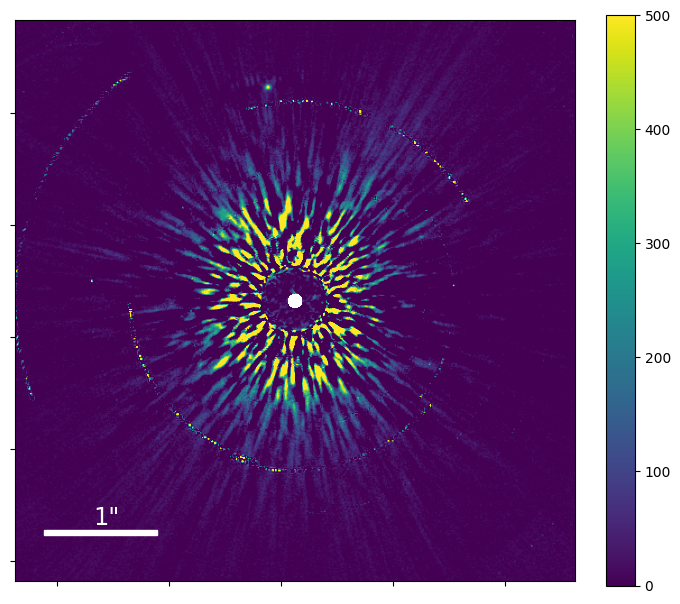

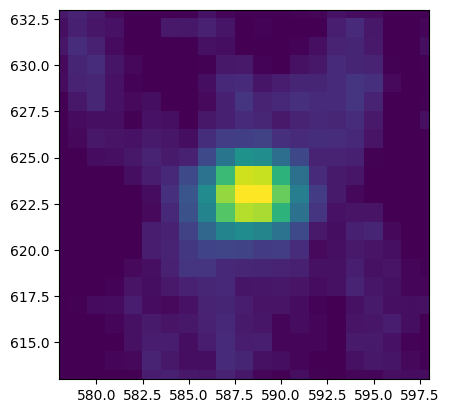

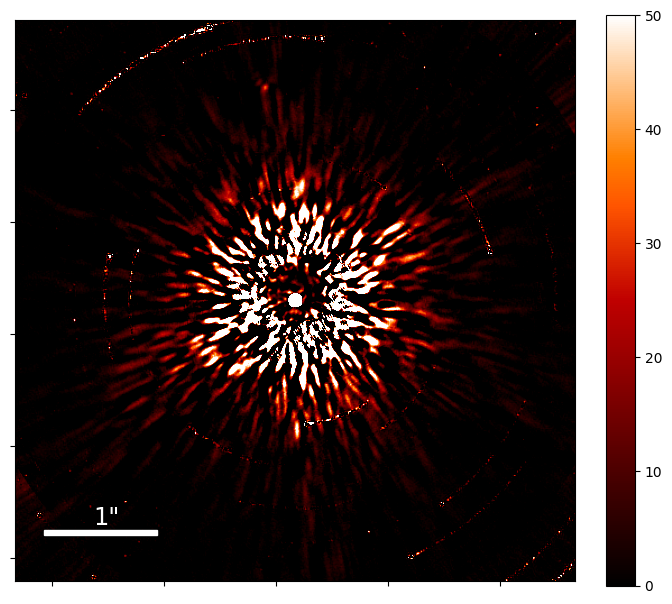

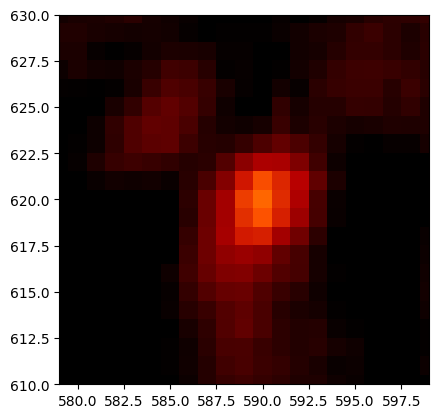

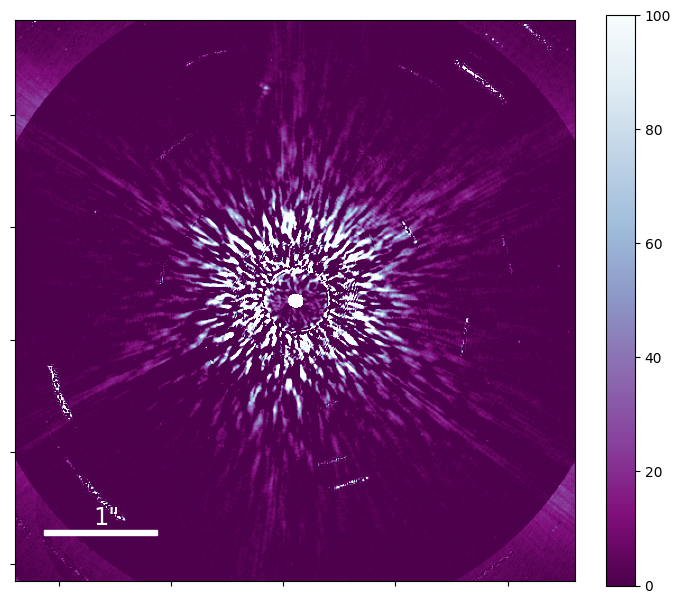

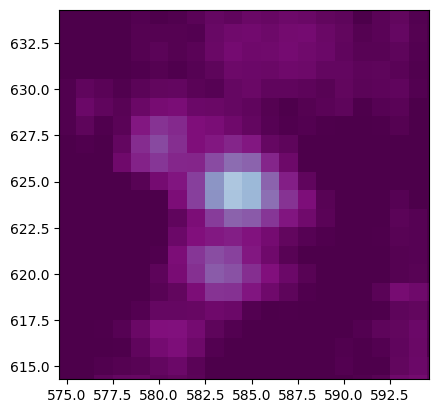

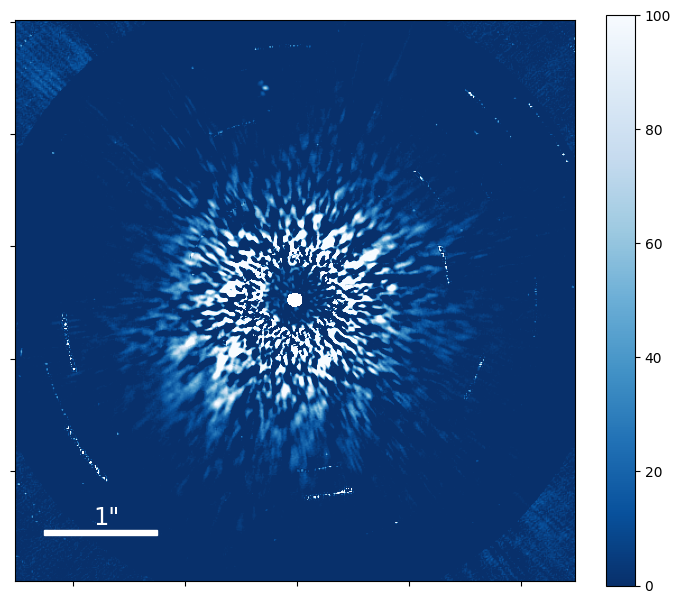

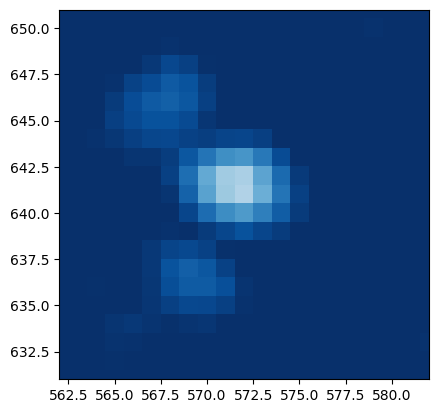

In [22]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

bands = ['2023_02_H', '2023_12_Kshort', '2023_12_J', '2023_12_CH4short']
vmaxes = {
    '2023_02_H': 500,
    '2023_12_Kshort': 50,
    '2023_12_J': 100,
    '2023_12_CH4short': 100
}
colors = {
    '2023_02_H': 'viridis',
    '2023_12_Kshort': 'gist_heat',
    '2023_12_J': 'BuPu_r',
    '2023_12_CH4short': 'Blues_r'
}

ctrs = {
    '2023_02_H': (433.833 - 1, 613.833 - 1),
    '2023_12_Kshort': (431 - 1, 618 - 1),
    '2023_12_CH4short': (453 - 1, 599.4 - 1),
    '2023_12_J': (436 - 1, 611.5 - 1)
}

planet_placement = {
    '2023_02_H': (624 - 1, 589 - 1), 
    '2023_12_Kshort': (621 - 1, 590 - 1),
    '2023_12_CH4short': (642 - 1, 573 - 1),
    '2023_12_J': (625.3 - 1, 585.6 - 1)
}

for band in bands:
    datadir = f'../fmdata/FM_{band}/fwhm='
    hdulist = fits.open(datadir + 'f-klipped-KLmodes-all.fits')
    image = hdulist[0].data[2]

    plt.figure(figsize=(8,8))
    plt.imshow(image, cmap=colors[band], origin='lower', vmin=0, vmax=vmaxes[band])

    # cx, cy = 603, 433

    # if band == '2023_12_CH4short':
    #     cx = 593

    cy, cx = ctrs[band]
        
    boxrad = 250
    plt.xlim(cx - boxrad, cx + boxrad)
    plt.ylim(cy - boxrad, cy + boxrad)
    plt.xticks(visible=False)
    plt.yticks(visible=False)
    plt.colorbar(aspect=20, fraction=.046)
    # plt.title(f'{band}')

    ax = plt.gca()
    scalebar = AnchoredSizeBar(ax.transData,
                               100.5,
                               "",     #label text
                               loc='lower left',
                               pad=2.0,
                               color='white',
                               frameon=False,
                               size_vertical=4)
    ax.add_artist(scalebar)
    plt.text(cx - boxrad + 70, cy - boxrad + 50, '1"', fontsize='xx-large', color='w')

    
    plt.savefig(band + '_KLIP-reduced.pdf')
    plt.show()


    plt.imshow(image, cmap=colors[band], origin='lower', vmin=0, vmax=vmaxes[band])

    cy, cx = planet_placement[band]
    mini_boxrad = 10
    plt.xlim(cx - mini_boxrad, cx + mini_boxrad)
    plt.ylim(cy - mini_boxrad, cy + mini_boxrad)
    plt.savefig(band + '_KLIP-reduced_mini.pdf')
    

In [8]:
print('Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r')

Accent Accent_r Blues Blues_r BrBG BrBG_r BuGn BuGn_r BuPu BuPu_r CMRmap CMRmap_r Dark2 Dark2_r GnBu GnBu_r Grays Greens Greens_r Greys Greys_r OrRd OrRd_r Oranges Oranges_r PRGn PRGn_r Paired Paired_r Pastel1 Pastel1_r Pastel2 Pastel2_r PiYG PiYG_r PuBu PuBuGn PuBuGn_r PuBu_r PuOr PuOr_r PuRd PuRd_r Purples Purples_r RdBu RdBu_r RdGy RdGy_r RdPu RdPu_r RdYlBu RdYlBu_r RdYlGn RdYlGn_r Reds Reds_r Set1 Set1_r Set2 Set2_r Set3 Set3_r Spectral Spectral_r Wistia Wistia_r YlGn YlGnBu YlGnBu_r YlGn_r YlOrBr YlOrBr_r YlOrRd YlOrRd_r afmhot afmhot_r autumn autumn_r binary binary_r bone bone_r brg brg_r bwr bwr_r cividis cividis_r cool cool_r coolwarm coolwarm_r copper copper_r cubehelix cubehelix_r flag flag_r gist_earth gist_earth_r gist_gray gist_gray_r gist_grey gist_heat gist_heat_r gist_ncar gist_ncar_r gist_rainbow gist_rainbow_r gist_stern gist_stern_r gist_yarg gist_yarg_r gist_yerg gnuplot gnuplot2 gnuplot2_r gnuplot_r gray gray_r grey hot hot_r hsv hsv_r inferno inferno_r jet jet_r m